# Dependencies

In [1]:
# Paths and directories
import os
import shutil

# Data Science basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rand

# Image processing
import cv2
import matplotlib.image as mpimg 

# Useful Code

In [2]:
# Functions to copy all sampled images to a working directory
def copy_to_test_dir(df):
    
    """
    Copy resized images to a test directory
    """
    
    # read image
    img = cv2.imread(df['img_path'], cv2.IMREAD_UNCHANGED)
    
    # resize and set colour channels
    new_img = cv2.resize(img, (356, 356), interpolation = cv2.INTER_AREA)
#     new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    
    # save to new dir
    cv2.imwrite(os.path.join(test_dir, df['family'], df['image']), new_img)
    
    return
    
def copy_to_train_dir(df):
    
    """
    Copy resized images to a train directory
    """
    
    # read image
    img = cv2.imread(df['img_path'], cv2.IMREAD_UNCHANGED)
    
    # resize and set colour channels
    new_img = cv2.resize(img, (356, 356), interpolation = cv2.INTER_AREA)
#     new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    
    # save to new dir
    cv2.imwrite(os.path.join(train_dir, df['family'], df['image']), new_img)
    
    return

# Import Data

In [3]:
# Read in training data
train_csv = pd.read_csv('../input/happy-whale-and-dolphin/train.csv')

# Make a column with the path to an image
images_dir = os.path.join('../input/happy-whale-and-dolphin/train_images')
train_csv['img_path'] = train_csv['image'].apply(lambda x: os.path.join(images_dir, x))

# Drop individual_id
train_csv.drop(columns = ['individual_id'], axis = 1, inplace = True)

train_csv.head()

,image,species,img_path
0,00021adfb725ed.jpg,melon_headed_whale,../input/happy-whale-and-dolphin/train_images/...
1,000562241d384d.jpg,humpback_whale,../input/happy-whale-and-dolphin/train_images/...
2,0007c33415ce37.jpg,false_killer_whale,../input/happy-whale-and-dolphin/train_images/...
3,0007d9bca26a99.jpg,bottlenose_dolphin,../input/happy-whale-and-dolphin/train_images/...
4,00087baf5cef7a.jpg,humpback_whale,../input/happy-whale-and-dolphin/train_images/...


## Cleaning

In [4]:
sorted(train_csv['species'].unique())

['beluga',
 'blue_whale',
 'bottlenose_dolphin',
 'bottlenose_dolpin',
 'brydes_whale',
 'commersons_dolphin',
 'common_dolphin',
 'cuviers_beaked_whale',
 'dusky_dolphin',
 'false_killer_whale',
 'fin_whale',
 'frasiers_dolphin',
 'globis',
 'gray_whale',
 'humpback_whale',
 'kiler_whale',
 'killer_whale',
 'long_finned_pilot_whale',
 'melon_headed_whale',
 'minke_whale',
 'pantropic_spotted_dolphin',
 'pilot_whale',
 'pygmy_killer_whale',
 'rough_toothed_dolphin',
 'sei_whale',
 'short_finned_pilot_whale',
 'southern_right_whale',
 'spinner_dolphin',
 'spotted_dolphin',
 'white_sided_dolphin']

In [5]:
# Correcting spelling mistakes
train_csv.species = train_csv['species'].replace({'bottlenose_dolpin':'bottlenose_dolphin', 'kiler_whale':'killer_whale'})

# Dropping globis and pilot whale - referring to the genus instead of the species
train_csv = train_csv.loc[(train_csv['species'] != 'globis') & (train_csv['species'] != 'pilot_whale')].copy()

## Taxonomic Mapping

In [6]:
# Read in data gathered here: https://www.kaggle.com/datasets/chasset/happywhalespeciesclassification?select=species.csv
# on species taxonomy

taxonomy = pd.read_csv('../input/happywhalespeciesclassification/species.csv')

# Drop columns except family and genus
taxonomy.drop(columns = ['wikipedia', 'image', 'size', 'specy', 'infraorder'], axis = 1, inplace = True) 

# Correct taxonomy table to represent both species of globis
taxonomy.loc[taxonomy.specy_id == 'pilot_whale', 'specy_id'] = 'long_finned_pilot_whale'

# Correct taxonomy table to be consistent casing
taxonomy.loc[taxonomy.specy_id == 'bottlenose_dolphin', 'genus'] = 'Tursiops' # not 'tursiops'

# Dictionary to map observations in df
taxonomy_dic = taxonomy.set_index('specy_id').to_dict('index')

taxonomy.sort_values('family') # view species per family

,specy_id,family,genus
12,southern_right_whale,Balaenidae,Eubalaena
2,humpback_whale,Balaenopteridae,Megaptera
3,blue_whale,Balaenopteridae,Balaenoptera
20,brydes_whale,Balaenopteridae,Balaenoptera
8,minke_whale,Balaenopteridae,Balaenoptera
10,fin_whale,Balaenopteridae,Balaenoptera
11,gray_whale,Balaenopteridae,Eschrichtius
14,sei_whale,Balaenopteridae,Balaenoptera
23,pygmy_killer_whale,Delphinidae,Feresa
22,commersons_dolphin,Delphinidae,Cephalorhynchus


In [7]:
# Map dictionary to training data - include family and genus for every observation
train_csv['family'] = train_csv['species'].apply(lambda x: taxonomy_dic[x]['family'])
train_csv['genus'] = train_csv['species'].apply(lambda x: taxonomy_dic[x]['genus'])

train_csv.head()

,image,species,img_path,family,genus
0,00021adfb725ed.jpg,melon_headed_whale,../input/happy-whale-and-dolphin/train_images/...,Delphinidae,Peponocephala
1,000562241d384d.jpg,humpback_whale,../input/happy-whale-and-dolphin/train_images/...,Balaenopteridae,Megaptera
2,0007c33415ce37.jpg,false_killer_whale,../input/happy-whale-and-dolphin/train_images/...,Delphinidae,Pseudorca
3,0007d9bca26a99.jpg,bottlenose_dolphin,../input/happy-whale-and-dolphin/train_images/...,Delphinidae,Tursiops
4,00087baf5cef7a.jpg,humpback_whale,../input/happy-whale-and-dolphin/train_images/...,Balaenopteridae,Megaptera


# Resize and save images
## Generate necessary directories for splitting data

The current directory structure is:

```
/train_images
/test_images
```

However the image generator we are using to input data into our models needs this structure:

```
/train_images
    /Delphinidae
    /Baleanidae
    ...
/test_images
    /Delphinidae
    /Baleanidae
    ...
```

In [8]:
# Make top level directories
train_dir = os.path.join('./train_set')
os.mkdir('test_set')

test_dir = os.path.join('./test_set')
os.mkdir('train_set')

In [9]:
# Make lower level directories
for fam in train_csv['family'].unique():
    os.mkdir(os.path.join(train_dir, fam))
    os.mkdir(os.path.join(test_dir, fam))

## Sample, train/test split and save images

In [10]:
# Making a sample of row indexes from which to subset the data
# These indexes will equally representat all families (1250 obs each) except the Ziiphidae family,
# which only has 341 observations.

# Set seed for reproducibility 
rand.seed(42)

# List to append to through iteration over family level subsets of data
sampled_families = []
for fam in train_csv['family'].unique():
    
    fam_subset = list(train_csv.loc[train_csv['family'] == fam].index) # indeces of a df with observations for a given family
    
    if len(fam_subset) > 900:
        fam_subset = rand.sample(fam_subset, 1250) # sample 1250 observations
        
    sampled_families.extend(fam_subset) # append

In [11]:
# Split data to then move corresponding images to previously created directories
X = train_csv.loc[sampled_families]
y = train_csv.loc[sampled_families, 'family']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y) # the same seed is used here

In [12]:
# Apply functions over split data, to read in paths
# Returned from .apply are empty arrays, they can be deleted
to_delete = X_test.apply(copy_to_test_dir, axis = 1)    
to_delete = X_train.apply(copy_to_train_dir, axis = 1)

del to_delete

# EDA

In [13]:
# Taking a look at our sample
sample_csv = train_csv.loc[sampled_families,].copy().reset_index(drop = True)
sample_csv.head()

,image,species,img_path,family,genus
0,d536e86af113d2.jpg,melon_headed_whale,../input/happy-whale-and-dolphin/train_images/...,Delphinidae,Peponocephala
1,253f5043822c12.jpg,bottlenose_dolphin,../input/happy-whale-and-dolphin/train_images/...,Delphinidae,Tursiops
2,0879287904f279.jpg,bottlenose_dolphin,../input/happy-whale-and-dolphin/train_images/...,Delphinidae,Tursiops
3,f75296ec47f806.jpg,killer_whale,../input/happy-whale-and-dolphin/train_images/...,Delphinidae,Orcinus
4,5c500821f53885.jpg,dusky_dolphin,../input/happy-whale-and-dolphin/train_images/...,Delphinidae,Lagenorhynchus


In [14]:
def abs_val(p, vals):
    
    """Returns the count of observations in a class given the percentage and totals"""
    
    return round((p / 100) * sum(vals))

def pie_var(df, var):
    
    """Make a pie chart displaying counts of each class given a column name and data frame"""
    
    sp_summary = df[var].value_counts()
    plt.figure(figsize = (10, 10))
    plt.title('Count per '+var)
    labs = list(sp_summary.index)
    plt.pie(sp_summary, labels = labs, autopct = lambda p: abs_val(p, sp_summary.values) if p > 1 else None)
    plt.show()
    
    return

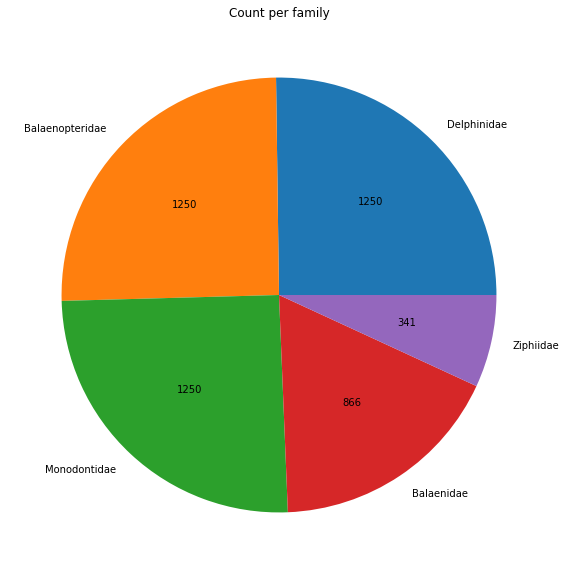

In [15]:
pie_var(sample_csv, 'family')

In [16]:
# Define paths to directories
train_dir = os.path.join('../input/happywhale-sample-resized/train_set')
test_dir = os.path.join('../input/happywhale-sample-resized/test_set')

In [73]:
def plot_fam_sample(fam, n_subpl = 3, photo_dir = train_dir):
    
    """Plot a subsample of data of a desired size for a specific family"""
    
    # Path to photos of the family
    fam_path = os.path.join(photo_dir, fam)
    
    # List of all the photos
    all_photos = os.listdir(fam_path)
    
    # Sample of list of all photos
    sample_photos = rand.sample(all_photos, n_subpl)
    
    # Plot sample
    plt.figure(figsize = (10,10))
    for photo in range(len(sample_photos)): # iterate through photos of a sample to plot as subplots
        plt.subplot(int(n_subpl/3), 3, photo + 1)
        img = cv2.imread(os.path.join(fam_path, sample_photos[photo]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        if photo + 1 == 2:
            plt.title(fam, fontsize = 'xx-large')
    plt.show()

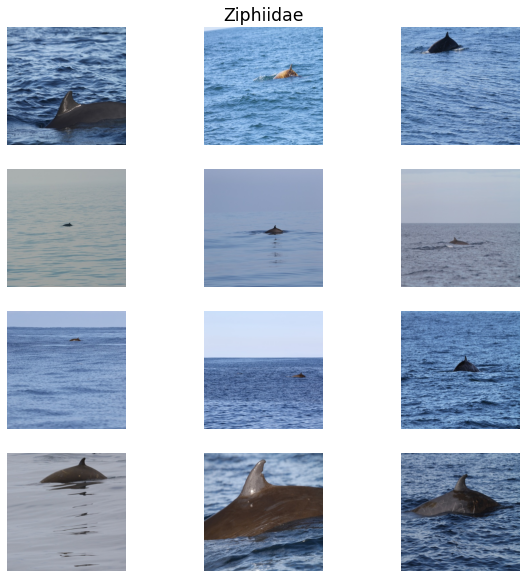

In [74]:
plot_fam_sample('Ziphiidae', n_subpl = 12)